# PyOD, Anamoly Detection

[PyOD](https://pyod.readthedocs.io/en/latest/) is a unified outlier detection API. Let's see how we can use it to detect outliers.

## Data

We will generate `inlier` and `outlier` data according to normal distributions. The inlier distribution is as follows.

- $\mathcal{N}(0, 1)$

The outlier distributions are as follows.

- $\mathcal{N}(2, 1)$
- $\mathcal{N}(3, 1)$
- $\mathcal{N}(4, 1)$
- $\mathcal{N}(10, 1)$

We will sample 1,000 samples from the inlier distribution and 100 samples from each outlier distribution for a total of 1,400 samples. Here, $X$ will be all the samples merged and $y$ will be a binary vector where 0 indicates inlier and 1 indicates outlier.

In [1]:
import numpy as np
import pandas as pd
import random as rand

np.random.seed(37)
rand.seed(37)

N = 1_000

a = np.random.normal(0, 1, N)
b = np.random.normal(2, 1, 100)
c = np.random.normal(3, 1, 100)
d = np.random.normal(4, 1, 100)
e = np.random.normal(10, 1, 100)

X = pd.DataFrame({'x0': np.concatenate([a, b, c, d, e])})
y = np.concatenate([
    np.zeros(N),
    np.ones(100),
    np.ones(100),
    np.ones(100),
    np.ones(100)
])

X.shape, y.shape

((1400, 1), (1400,))

Let's visualize the distribution of $X$ and $y$. We will visualize $X$ at different bandwidths for the kernel density estimation (KDE).

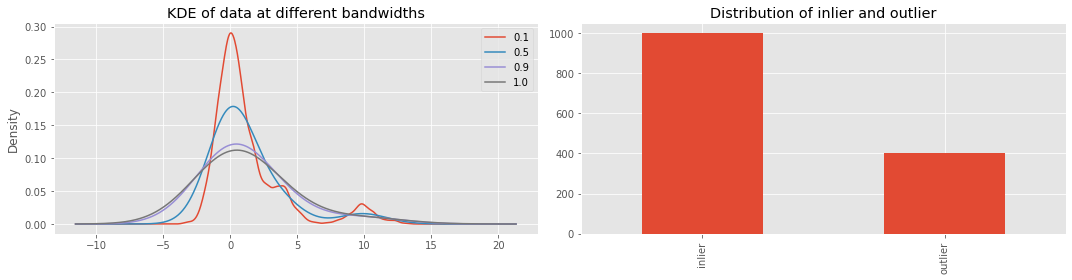

In [2]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for bw in [0.1, 0.5, 0.9, 1.0]:
    _ = X['x0'].plot(kind='kde', bw_method=bw, ax=ax[0], label=f'{bw:.1f}')

_ = ax[0].legend()
_ = ax[0].set_title('KDE of data at different bandwidths')

s = pd.Series(y).value_counts().sort_index()
s.index = ['inlier', 'outlier']
_ = s.plot(kind='bar', ax=ax[1])

_ = ax[1].set_title('Distribution of inlier and outlier')

plt.tight_layout()

## Isolation Forest

[Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) is an approach to detect outliers. The predictions are -1 for outlier and 1 for inlier.

In [3]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_jobs=-1, random_state=37)
y_pred = iso.fit_predict(X)

Here, we visualize the distribution of the predictions.

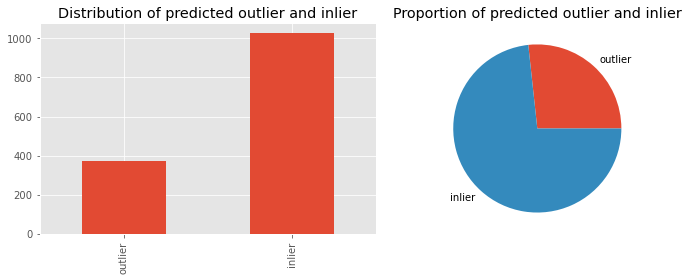

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

s = pd.Series(y_pred).value_counts().sort_index()
s.index = ['outlier', 'inlier']

s.plot(kind='bar', ax=ax[0])
s.plot(kind='pie', ax=ax[1])

_ = ax[1].set_ylabel('')
_ = ax[0].set_title('Distribution of predicted outlier and inlier')
_ = ax[1].set_title('Proportion of predicted outlier and inlier')

plt.tight_layout()

We can benchmark the (non-validated) performance of the Isolation Forest model using 

- [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
- [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)
- [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

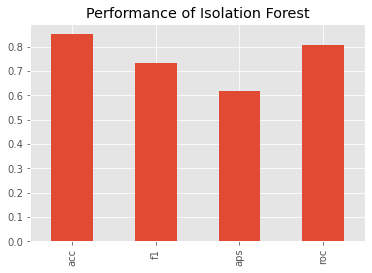

In [5]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

y_p = np.array([0 if v == 1 else 1 for v in y_pred])

s = pd.Series([
    accuracy_score(y, y_p), 
    f1_score(y, y_p), 
    average_precision_score(y, y_p), 
    roc_auc_score(y, y_p)
], index=['acc', 'f1', 'aps', 'roc'])

_ = s.plot(kind='bar', title='Performance of Isolation Forest')

Here is the confusion matrix.

- P_N: predicted negative
- P_P: predicted positive
- T_N: true negative
- T_P: true positive

In [6]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y, y_p), columns=['P_N', 'P_P'], index=['T_N', 'T_P'])

,P_N,P_P
T_N,909,91
T_P,117,283


Now let's plot the following distributions.

- true vs predicted inliers
- true vs predicted outliers

It seems Isolation Forest is having problems detecting outliers more than inliers.

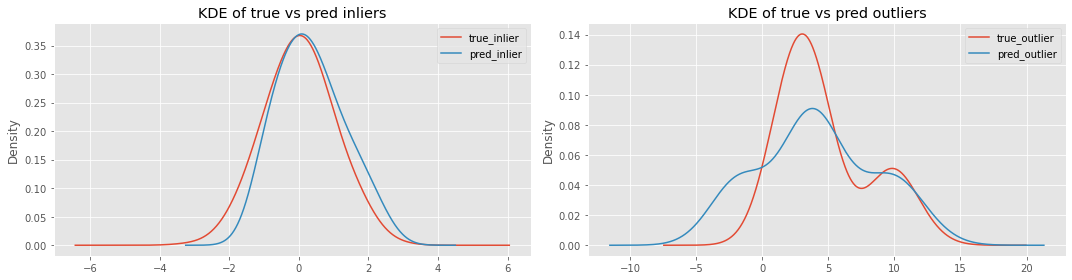

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

_ = X[y == 0].x0.plot(kind='kde', bw_method=0.5, ax=ax[0], label='true_inlier')
_ = X[y_p == 0].x0.plot(kind='kde', bw_method=0.5, ax=ax[0], label='pred_inlier')

_ = X[y == 1].x0.plot(kind='kde', bw_method=0.5, ax=ax[1], label='true_outlier')
_ = X[y_p == 1].x0.plot(kind='kde', bw_method=0.5, ax=ax[1], label='pred_outlier')

_ = ax[0].legend()
_ = ax[1].legend()

_ = ax[0].set_title('KDE of true vs pred inliers')
_ = ax[1].set_title('KDE of true vs pred outliers')

plt.tight_layout()

Now, let's plot the distributions of 

- TN: true negative
- FP: false positive
- FN: false negative
- TP: true positive

Look at the KDE plots for FP and FN. 

- The FP samples belong to the inlier class, but were predicted as outlier; the distribution is to the left of the TN curve. 
- The FN samples belong to the outlier class, but were predicted as inlier; the distribution is to the right of the TN cruve.

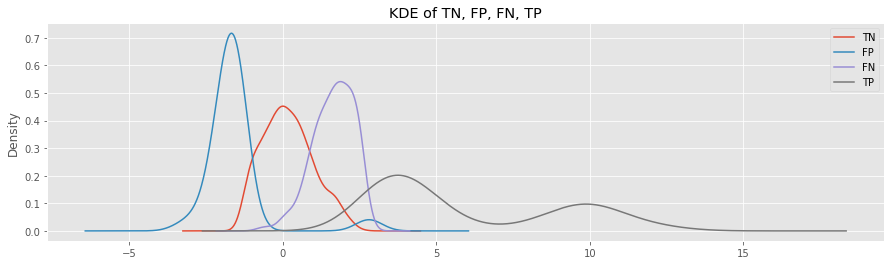

In [8]:
fig, ax = plt.subplots(figsize=(15, 4))

_ = X[(y== 0) & (y_p == 0)].x0.plot(kind='kde', label='TN', ax=ax)
_ = X[(y== 0) & (y_p == 1)].x0.plot(kind='kde', label='FP', ax=ax)
_ = X[(y== 1) & (y_p == 0)].x0.plot(kind='kde', label='FN', ax=ax)
_ = X[(y== 1) & (y_p == 1)].x0.plot(kind='kde', label='TP', ax=ax)

_ = ax.set_title('KDE of TN, FP, FN, TP')

_ = ax.legend()

## K-Nearest Neighbor

[K-nearest neighbor](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn) (KNN) from PyOD can be used to detect outliers. However, we have to give KNN some hints about the proportion of contamination (proportion of outliers). Since we generated the data, we know the contamination is about 0.30.

In [9]:
from pyod.models.knn import KNN

knn = KNN(contamination=0.30, n_jobs=-1)
knn.fit(X)

y_pred = knn.predict(X)

Let's look at the distribution of predicted inliers and outliers by KNN.

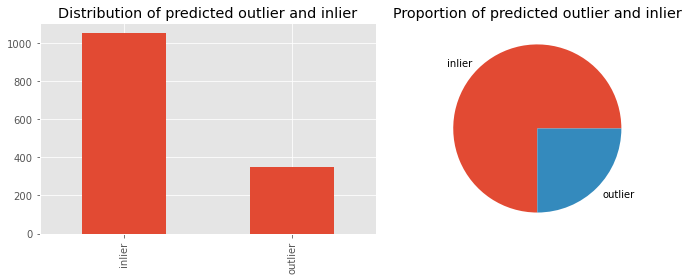

In [10]:
s = pd.Series(y_pred).value_counts().sort_index()
s.index = ['inlier', 'outlier']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

s.plot(kind='bar', ax=ax[0])
s.plot(kind='pie', ax=ax[1])

_ = ax[1].set_ylabel('')
_ = ax[0].set_title('Distribution of predicted outlier and inlier')
_ = ax[1].set_title('Proportion of predicted outlier and inlier')

plt.tight_layout()

What about the (non-validated) performance? Based on the average precision score, KNN performed slightly worse than Isolation Forest.

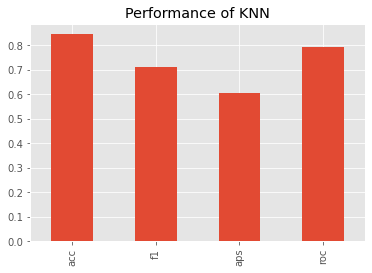

In [11]:
y_p = y_pred

s = pd.Series([
    accuracy_score(y, y_p), 
    f1_score(y, y_p), 
    average_precision_score(y, y_p), 
    roc_auc_score(y, y_p)
], index=['acc', 'f1', 'aps', 'roc'])

_ = s.plot(kind='bar', title='Performance of KNN')

Here's the confusion matrix for the KNN predictions. Compared to Isolation Forest, KNN has a tougher time predicting the positive examples and Isolation Forest has a tougher time predicting the negative examples.

In [12]:
pd.DataFrame(confusion_matrix(y, y_p), columns=['P_N', 'P_P'], index=['T_N', 'T_P'])

,P_N,P_P
T_N,917,83
T_P,133,267


Let's plot the KIDE of true vs predicted inliers and true vs predicted outliers for KNN.

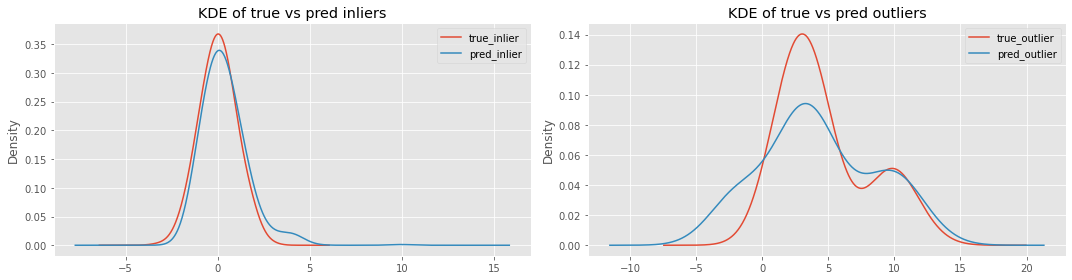

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

_ = X[y == 0].x0.plot(kind='kde', bw_method=0.5, ax=ax[0], label='true_inlier')
_ = X[y_p == 0].x0.plot(kind='kde', bw_method=0.5, ax=ax[0], label='pred_inlier')

_ = X[y == 1].x0.plot(kind='kde', bw_method=0.5, ax=ax[1], label='true_outlier')
_ = X[y_p == 1].x0.plot(kind='kde', bw_method=0.5, ax=ax[1], label='pred_outlier')

_ = ax[0].legend()
_ = ax[1].legend()

_ = ax[0].set_title('KDE of true vs pred inliers')
_ = ax[1].set_title('KDE of true vs pred outliers')

plt.tight_layout()

These are the KDE plots for TN, FP, FN and TP generated by KNN.

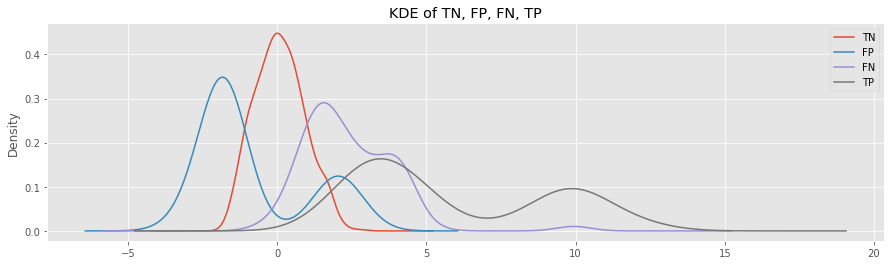

In [14]:
fig, ax = plt.subplots(figsize=(15, 4))

_ = X[(y== 0) & (y_p == 0)].x0.plot(kind='kde', label='TN', ax=ax)
_ = X[(y== 0) & (y_p == 1)].x0.plot(kind='kde', label='FP', ax=ax)
_ = X[(y== 1) & (y_p == 0)].x0.plot(kind='kde', label='FN', ax=ax)
_ = X[(y== 1) & (y_p == 1)].x0.plot(kind='kde', label='TP', ax=ax)

_ = ax.set_title('KDE of TN, FP, FN, TP')

_ = ax.legend()

What happens if we vary the contamination value in the range [0.1, 0.5]?

In [15]:
r_df = []

for c in np.arange(0.1, 0.5+0.01, 0.01):
    knn = KNN(contamination=c, n_jobs=-1)
    knn.fit(X)

    y_p = knn.predict(X)
    
    r = {
        'contamination': c,
        'acc': accuracy_score(y, y_p),
        'f1': f1_score(y, y_p),
        'aps': average_precision_score(y, y_p),
        'roc': roc_auc_score(y, y_p)
    }
    r_df.append(r)
    
r_df = pd.DataFrame(r_df)
r_df.index = r_df.contamination

We can see that as we move from 0.1 to the true contamination proportion, the performance measures increase, and, after which, the performances start to degrade. It seems getting the contamination parameter correct is crucial to optimal performance.

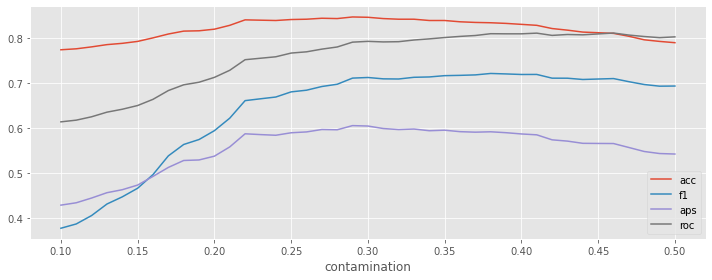

In [16]:
_, ax = plt.subplots(figsize=(10, 4))

_ = r_df['acc'].plot(kind='line', ax=ax)
_ = r_df['f1'].plot(kind='line', ax=ax)
_ = r_df['aps'].plot(kind='line', ax=ax)
_ = r_df['roc'].plot(kind='line', ax=ax)

_ = ax.legend()

plt.tight_layout()

### Combination

But, we will never know the amount of contamination or outliers in our data. No worries, since we can create an ensemble of KNN models and aggregate across them for a final prediction. We get two benefits; we no longer need to fine-tune the contamination parameter and we get an ensemble model [that should do better than a single model](https://pyod.readthedocs.io/en/latest/example.html).

In this approach, we create a large ensemble of KNN to detect outliers. The `contamination` and `n_neighbors` are both varied constantly in the ranges $[0.1, 0.5]$ by 0.01 and $[10, 210]$ by 10, respectively.

In [17]:
import itertools
from pyod.utils.utility import standardizer

def do_learn(n, c):
    knn = KNN(contamination=c, n_neighbors=n, n_jobs=-1)
    knn.fit(X)
    return knn.predict(X)

def get_key(n, c):
    return f'n_{n:03}_c={c:.2f}'
    
n_neighbors = list(np.arange(10, 210, 10))
contaminations = list(np.arange(0.1, 0.5 + 0.01, 0.01))

r_df = pd.DataFrame({get_key(n, c): do_learn(n, c) 
                     for n, c in itertools.product(n_neighbors, contaminations)})
r_mat = standardizer(r_df)

The ensemble KNN may then be [aggregated by the following](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.combination).

- aom: Take the average of the maximums (each sample has multiple predictions, these predictions are put into sub-groups, and the average of the maximum of these sub-groups is computed).
- moa: Maximization of average (each sample has multiple predictions, these predictions are put into sub-groups, and the maximum of these sub-groups is computed);
- average: Take the average of the outlier scores.
- maximization: Take the maximum of the outlier scores.

Now, we can compute the performance of these KNN ensembles. The KNN ensembles have average precision scores over 0.80, while KNN alone and Isolation forest have 0.60. The AUC-ROC performance is also improved; KNN alone and Isolation Forest have 0.80, while KNN ensemble has over 0.90.

In [18]:
from pyod.models.combination import aom, moa, average, maximization

pd.DataFrame([{'score': f.__name__, 'roc': roc_auc_score(y, f(r_mat)), 'aps': average_precision_score(y, f(r_mat))} 
              for f in [average, moa, average, maximization]])

,score,roc,aps
0,average,0.930193,0.856301
1,moa,0.930248,0.856549
2,average,0.930193,0.856301
3,maximization,0.926509,0.824471
